In [18]:
import os
os.chdir("/Users/mammoc/Desktop/Python")
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from scipy.stats import kruskal

In [2]:
airport = pd.read_csv("airport_original1.csv", sep = ';', header = 0)

In [3]:
# Dropping rows where 'Destination' is 4
airport = airport[airport['Destination'] != 4]

In [4]:
###-------------- STEP 1: FILLING UP NAs ----------------

#Airline:
#For Incheon: Uniform distribution
airport.loc[airport['ID'].isin([69, 72]), 'Airline'] = 1.0
airport.loc[airport['ID'].isin([82, 83]), 'Airline'] = 2.0
airport.loc[airport['ID'].isin([89, 188]), 'Airline'] = 3.0
airport.loc[airport['ID'].isin([212, 214]), 'Airline'] = 4.0

#For Gimpo: Most frequency group
airport.loc[airport['ID'].isin([266, 314]), 'Airline'] = 4.0
#Drop NAs in Destination
airport = airport.dropna(subset=['Destination'])

#Age has 1 missing value (ID 214) => Replace by average age of 40
airport.loc[airport['ID'] == 214, 'Age'] = 40

#Gender has 3 missing values (ID 179, 199, 259)
# => Fill up by most frequency category - female - 2.0
airport.loc[airport['ID'].isin([179, 199, 259]), 'Gender'] = 2.0

#SeatClass has 3 missing value 
#Fill up by most frequency category = 1.0
airport.loc[airport['ID'].isin([245, 255, 450, 475]), 'SeatClass'] = 1.0

#AccessTime:
AccessTime_by_ProvinceResidence = airport.groupby('ProvinceResidence')['AccessTime'].mean()
airport['AccessTime'] = airport.apply(
    lambda row: AccessTime_by_ProvinceResidence[row['ProvinceResidence']] if pd.isnull(row['AccessTime']) 
    else row['AccessTime'],axis=1)

#Noticeable Difference in Airfare Between Legacy Airlines and Others
#print(airport.groupby('Airline[Legacy]')['Airfare'].mean())
#print(airport.groupby('Airline[Legacy]')['Airfare'].median())
# Recategorize 'Airline' into binary categories: 'Legacy' and 'Other'
airport['Airline[Legacy]'] = airport['Airline'].isin([1, 2]).astype(int)

#Airfare:
# Calculate the mean 'Airfare' for each combination of 'Airline_Legacy','Destination'
Airfare_by_Airline_Destination = airport.groupby(['Airline[Legacy]','Destination'])['Airfare'].mean()
#Fill the missing values in 'Airfare' with the average values calculated above
airport['Airfare'] = airport.apply(
    lambda row: Airfare_by_Airline_Destination[row['Airline[Legacy]'], row['Destination']] if pd.isnull(row['Airfare']) 
    else row['Airfare'], axis=1)


In [10]:
## --------- STEP 2: RE-CATEGORIZING Y ----------
#Assumption: There is a noticeable difference in Airfare between Legacy airlines and Other airlines:
#Re-group to airline[Legacy] and Others
airport['Airline[Legacy]'] = (airport['Airline'].isin([1,2])).astype(int)
#Checking for mean Airfare of each group:
print('\nMean Airfare of each group:')
print(airport.groupby('Airline[Legacy]')['Airfare'].mean())
#Comment: There is difference

#Checking sample size of each groups if they are relatively even:
print('\nChecking sample size:')
airport['Airline[Other]'] = airport['Airline'].isin([3,4]).astype(int)
print(airport['Airline[Legacy]'].sum())
print(airport['Airline[Other]'].sum())
#Comments: Even


Mean Airfare of each group:
Airline[Legacy]
0    45.510949
1    51.055423
Name: Airfare, dtype: float64

Checking sample size:
249
210


In [11]:
###-------------- STEP 3: EDA ----------------
### EDA will be conducted based on nature of each variables, using: 
#(1) Visualization, (2) ANOVA test, (2)KRUSKAL-WALLIS H-test, (3) CHI-SQUARE

Mean age by Airline:
Airline[Legacy]
0    37.885714
1    41.883534
Name: Age, dtype: float64


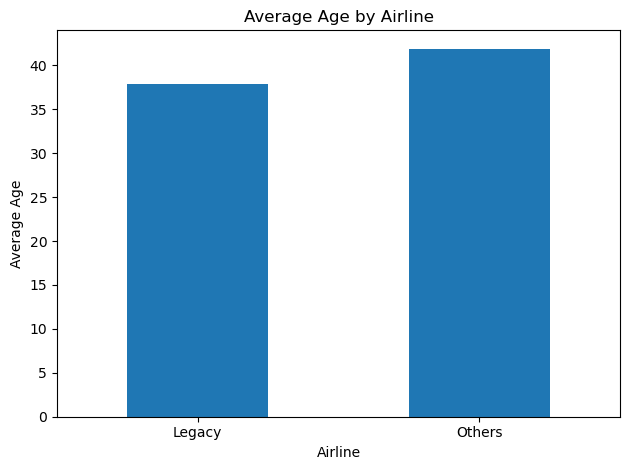

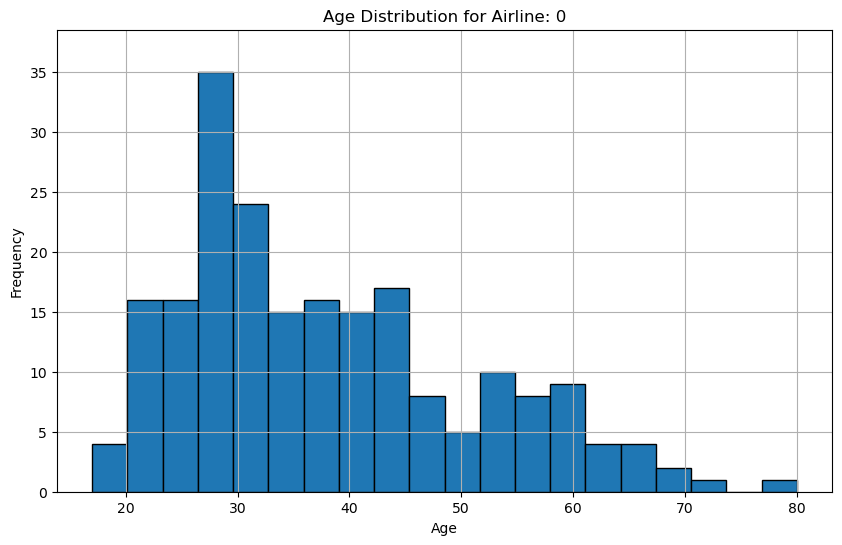

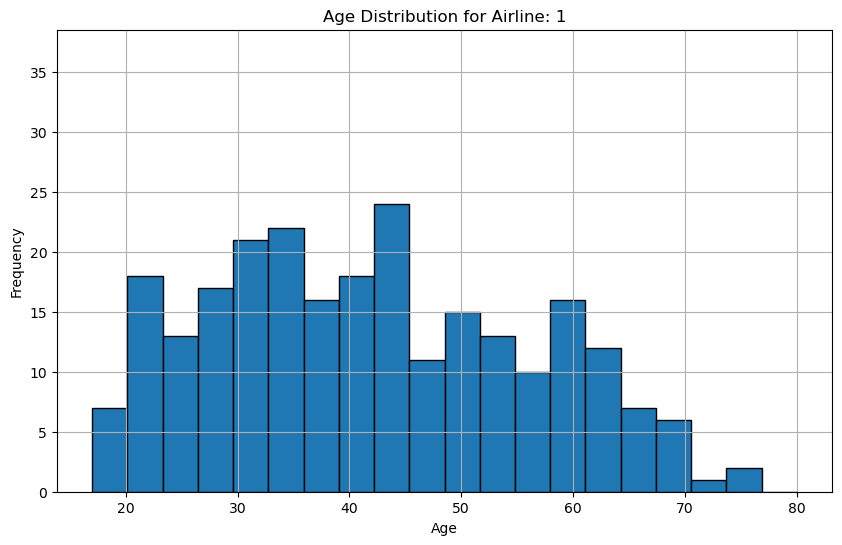


ANOVA test result:
The p-value is less than 0.1 , so we reject the null hypothesis.
There is a statistically significant difference in average age between Legacy airlines and Other airlines.


In [68]:
# -------- AGE ---------
print('Mean age by Airline:')
print(airport.groupby('Airline[Legacy]')['Age'].mean())

#(1)Visualization
avg_age_by_airport = airport.groupby('Airline[Legacy]')['Age'].mean()
avg_age_by_airport.index = ['Legacy', 'Others']
avg_age_by_airport.plot(kind='bar')
plt.xlabel('Airline')
plt.ylabel('Average Age')
plt.title('Average Age by Airline')
plt.xticks(rotation=0)  
plt.tight_layout()
plt.show()

#Histogram - Check for Normal Distribution
grouped = airport.groupby('Airline[Legacy]')
age_min = airport['Age'].min()
age_max = airport['Age'].max()
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['Age'], bins=20, range=(age_min, age_max))
    max_count = max(max_count, counts.max())
for i, (name, group) in enumerate(grouped, start=1):
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(group['Age'], bins=20, edgecolor='black', range=(age_min, age_max))    
    plt.ylim(0, max_count * 1.1)  # Add a little extra space at the top    
    plt.title(f'Age Distribution for Airline: {name}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    

#ANOVA Test
airport_1 = airport[airport['Airline[Legacy]'] == 1]['Age']
airport_2 = airport[airport['Airline[Legacy]'] == 0]['Age']
anova_result = f_oneway(airport_1, airport_2)
alpha = 0.1
print('\nANOVA test result:')
if anova_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average age between Legacy airlines and Other airlines.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average age between Legacy airlines and Other airlines.")

Airline[Legacy]  Gender
0                2.0       119
                 1.0        91
1                2.0       129
                 1.0       120
Name: count, dtype: int64


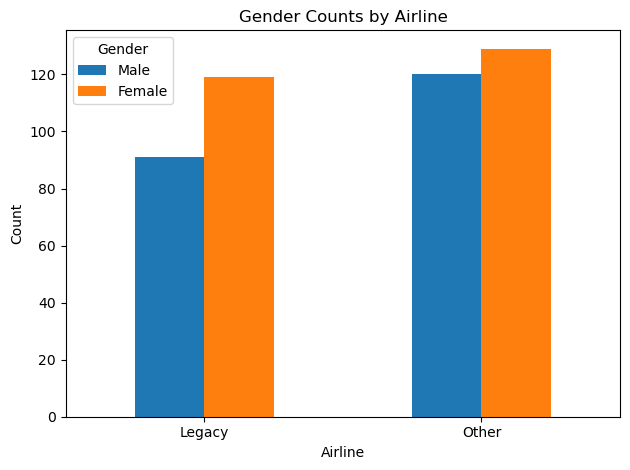


Chi-square test results:
Chi-square statistic: 0.8962882502228121
P-value: 0.34377892121550746

The p-value is greater than or equal to 0.05 , so we fail to reject the null hypothesis.
There is no statistically significant difference in the distribution of gender between Legacy airlines and Other airlines.


In [23]:
# --------- GENDER ---------
print(airport.groupby(['Airline[Legacy]'])['Gender'].value_counts())

#Visualization:
gender_counts = airport.groupby('Airline[Legacy]')['Gender'].value_counts().rename('Count').reset_index()
pivot_table = gender_counts.pivot(index='Airline[Legacy]', columns='Gender', values='Count').fillna(0)
pivot_table.index = ['Legacy', 'Other']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Gender Counts by Airline')
plt.xticks(ticks=[0, 1], labels=['Legacy', 'Other'], rotation=0)  
plt.legend(title='Gender', labels=['Male', 'Female'])  
plt.tight_layout()
plt.show()

#Chi-square test:
contingency_table = pd.crosstab(airport['Airline[Legacy]'], airport['Gender'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("\nChi-square test results:")
print("Chi-square statistic:", chi2)
print("P-value:", p)
alpha = 0.05
if p < alpha:
    print("\nThe p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in the distribution of gender between Legacy airlines and Other airlines.")
else:
    print("\nThe p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in the distribution of gender between Legacy airlines and Other airlines.")


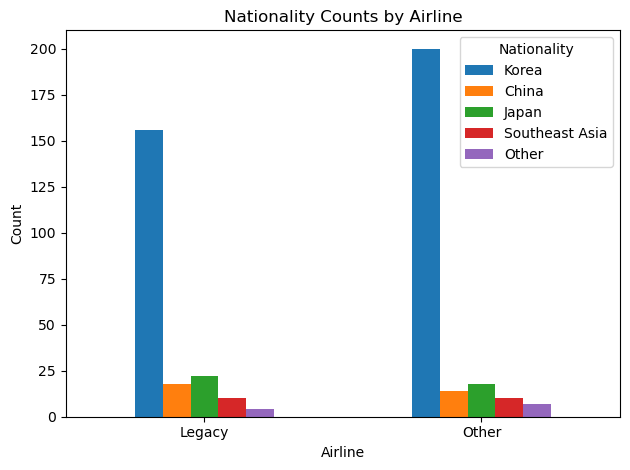

Chi-square test results for Nationality groups:
Chi-square statistic: 0.6511330992658793
P-value: 0.41970785812228983
Degrees of freedom: 1
The p-value for Nationality groups is greater than or equal to 0.1, so we fail to reject the null hypothesis.
There is no statistically significant association between Nationality and Airline selection.


In [120]:
#-------- NATIONALITY ------------
#Visualization:
# Group by 'Airport' and get the count of each 'Nationality'
nationality_counts = airport.groupby('Airline[Legacy]')['Nationality'].value_counts().rename('Count').reset_index()
pivot_table = nationality_counts.pivot(index='Airline[Legacy]', columns='Nationality', values='Count').fillna(0)
pivot_table.index = ['Legacy', 'Other']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Nationality Counts by Airline')
plt.xticks(ticks=[0, 1], labels=['Legacy', 'Other'], rotation=0)  
plt.legend(title='Nationality', labels=['Korea', 'China', 'Japan', 'Southeast Asia', 'Other'])  
plt.tight_layout()
plt.show()

#Chi-square:
airport['Nationality[Korean]'] = (airport['Nationality'].isin([1])).astype(int)
airport['Nationality[Japan]'] = (airport['Nationality'].isin([3])).astype(int)
airport['Nationality[SE]'] = (airport['Nationality'].isin([4])).astype(int)
airport['Nationality[China]'] = (airport['Nationality'].isin([2])).astype(int)
contingency_table = np.array([
    airport['Nationality[Korean]'].value_counts(),
    airport['Nationality[Japan]'].value_counts(),
    airport['Nationality[SE]'].value_counts(),
    airport['Nationality[China]'].value_counts()
])

#Chi-square:
airport['Nationality[Korean]'] = (airport['Nationality'].isin([1])).astype(int)
airport['Nationality[NotKorean]'] = (airport['Nationality'].isin([2,3,4])).astype(int)
contingency_table1 = np.array([
    airport['Nationality[Korean]'].value_counts(),
    airport['Nationality[NotKorean]'].value_counts(),
])

# Perform Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table1)

# Output the Chi-square test results
print(f"Chi-square test results for Nationality groups:\nChi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}")

# Interpret the results with an alpha of 0.05
alpha = 0.1
if p < alpha:
    print(f"The p-value for Nationality groups is less than {alpha}, so we reject the null hypothesis.")
    print("There is a statistically significant association between Nationality and Airline selection.")
else:
    print(f"The p-value for Nationality groups is greater than or equal to {alpha}, so we fail to reject the null hypothesis.")
    print("There is no statistically significant association between Nationality and Airline selection.")



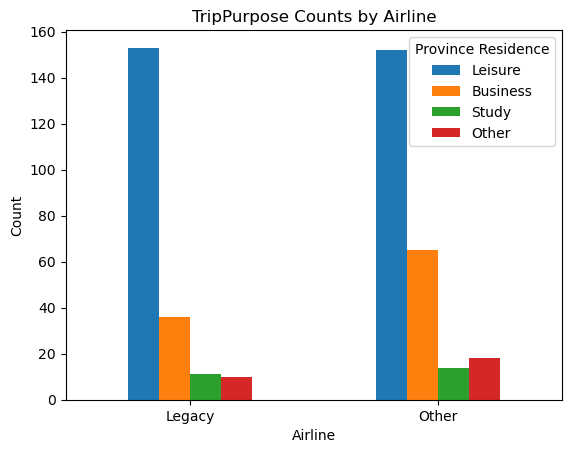

Chi-square test results for TripPurpose[Leisure] vs TripPurpose[Others]:
Chi-square statistic: 6.6106229183897005
P-value: 0.010137219514398792
Degrees of freedom: 1
The p-value for TripPurpose groups is less than 0.05, so we reject the null hypothesis.
There is a statistically significant association between TripPurpose and Airline selection.


In [121]:
#-------- TRIPPURPOSE ----------
#Visualization
TripPurpose_counts = airport.groupby('Airline[Legacy]')['TripPurpose'].value_counts().rename('Count').reset_index()
pivot_table = TripPurpose_counts.pivot(index='Airline[Legacy]', columns='TripPurpose', values='Count').fillna(0)
pivot_table.index = ['Legacy', 'Other']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('TripPurpose Counts by Airline')
plt.xticks(rotation=0)  
plt.legend(title='Province Residence', labels=['Leisure', 'Business', 'Study', 'Other'])  
plt.show()

#Chi-square:
airport['TripPurpose[Leisure]'] = (airport['TripPurpose'].isin([1])).astype(int)
airport['TripPurpose[Other]'] = (airport['TripPurpose'].isin([2,3,4])).astype(int)
contingency_table = pd.crosstab(index=airport['Airline[Legacy]'], columns=[airport['TripPurpose[Leisure]'], airport['TripPurpose[Other]']])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"Chi-square test results for TripPurpose[Leisure] vs TripPurpose[Others]:\nChi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}")
alpha = 0.05
if p < alpha:
    print(f"The p-value for TripPurpose groups is less than {alpha}, so we reject the null hypothesis.")
    print("There is a statistically significant association between TripPurpose and Airline selection.")
else:
    print(f"The p-value for TripPurpose groups is greater than or equal to {alpha}, so we fail to reject the null hypothesis.")
    print("There is no statistically significant association between TripPurpose and Airline selection.")

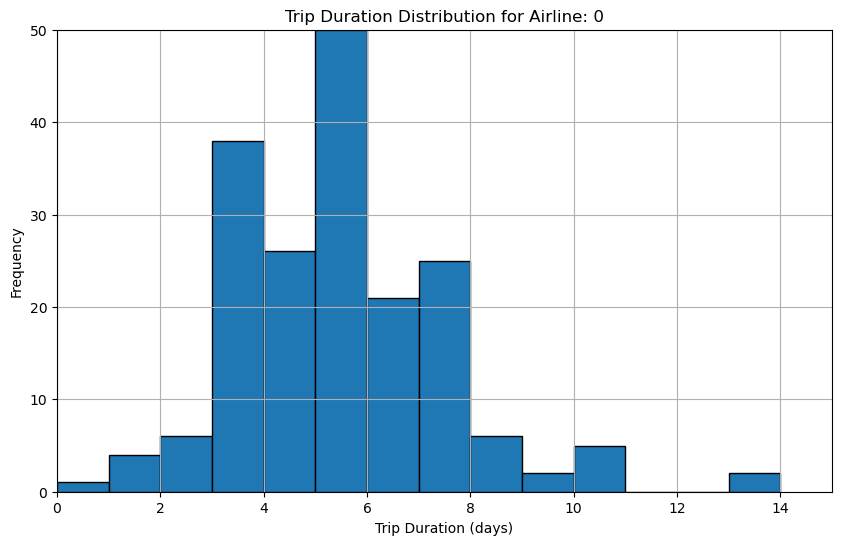

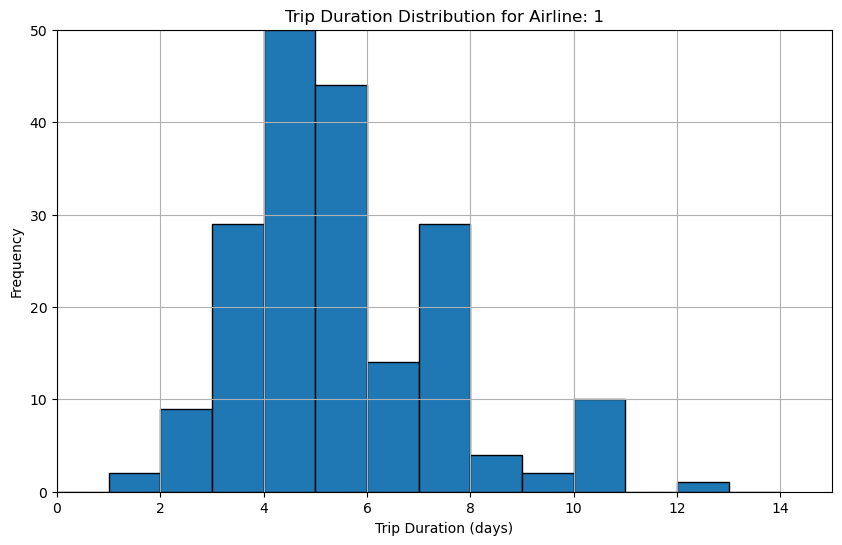

Sample size of each groups:
89
370

ANOVA test result:
ANOVA p-value: 0.02148282848433118
The p-value is less than 0.05 , so we reject the null hypothesis.
There is a statistically significant difference in average Trip Duration between Legacy airlines and Other airlines.


In [67]:
#-------- TRIPDURATION ----------
##Histogram - Check for Normal Distribution
# Filter out the outliers first
airport_filtered = airport[(airport['TripDuration'] <= 180)]
grouped = airport_filtered.groupby('Airline[Legacy]')
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['TripDuration'], bins=range(0, 15, 1))
    max_count = max(max_count, max(counts))
for name, group in grouped:
    plt.figure(figsize=(10, 6))
    plt.hist(group['TripDuration'], bins=range(0, 15, 1), edgecolor='black')
    plt.title(f'Trip Duration Distribution for Airline: {name}')
    plt.xlabel('Trip Duration (days)')
    plt.ylabel('Frequency')
    plt.ylim(0, max_count)  
    plt.xlim(0, 15)  
    plt.grid(True)
    plt.show()

#Check sample size of each group:
airport['TripDuration[<4]'] = (airport['TripDuration']<4).astype(int)
airport['TripDuration[>=4]'] = (airport['TripDuration']>=4).astype(int)
print('Sample size of each groups:')
print(airport['TripDuration[<4]'].sum())
print(airport['TripDuration[>=4]'].sum())

#ANOVA test:
airport_1 = airport[airport['Airline[Legacy]'] == 1]['TripDuration']
airport_2 = airport[airport['Airline[Legacy]'] == 0]['TripDuration']
anova_result = f_oneway(airport_1, airport_2)
alpha = 0.05
print('\nANOVA test result:')
print(f'ANOVA p-value: {anova_result.pvalue}')
if anova_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average Trip Duration between Legacy airlines and Other airlines.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average Trip Duration between Legacy airlines and Other airlines.")
    

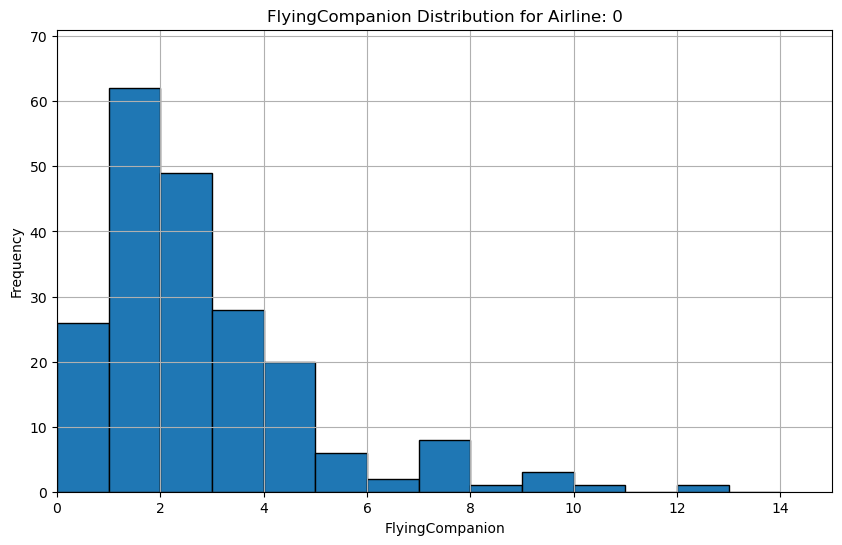

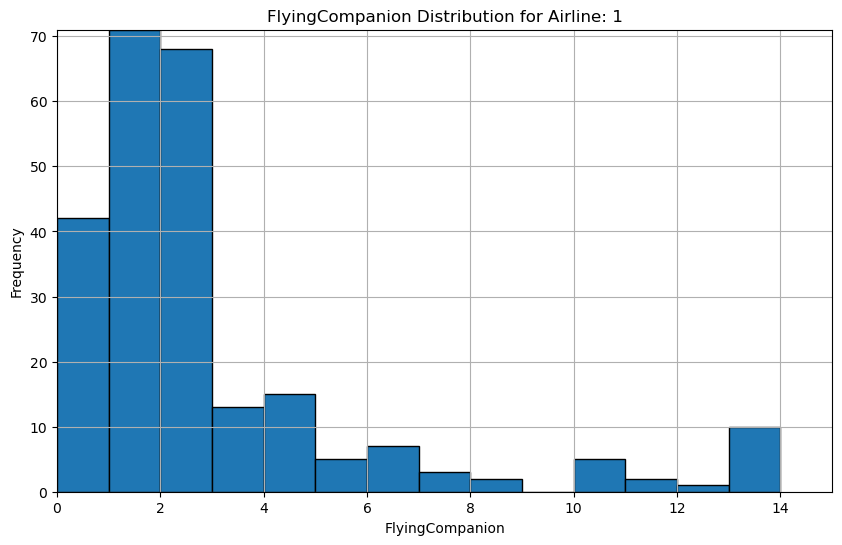

Sample size of each groups:
Airport
1    218
2    241
Name: FlyingCompanion, dtype: int64
\Kruskal-Wallis H Test test result:
Kruskal-Wallis H Test p-value: 0.07309185919228951
The p-value is greater than or equal to 0.01 , so we fail to reject the null hypothesis.
There is no statistically significant difference in average FlyingCompanion between Legacy airlines and Other airlines.

Chi-square test results for FlyingCompanion[>=3] vs FlyingCompanion[<3]:
Chi-square statistic: 2.6332255241070945
P-value: 0.10464892304391836
Degrees of freedom: 1
The p-value for FlyingCompanion groups is less than 0.11, so we reject the null hypothesis.
There is a statistically significant association between FlyingCompanion and Airport selection.


In [122]:
#--------- FLYING COMPANION -----------
##Histogram - Check for Normal Distribution
grouped = airport.groupby('Airline[Legacy]')
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['FlyingCompanion'], bins=range(0, 15, 1))
    max_count = max(max_count, max(counts))
for name, group in grouped:
    plt.figure(figsize=(10, 6))
    plt.hist(group['FlyingCompanion'], bins=range(0, 15, 1), edgecolor='black')
    plt.title(f'FlyingCompanion Distribution for Airline: {name}')
    plt.xlabel('FlyingCompanion')
    plt.ylabel('Frequency')
    plt.ylim(0, max_count) 
    plt.xlim(0, 15)  
    plt.grid(True)
    plt.show()
    
#Check for sample size of each group:
print('Sample size of each groups:')
print(airport.groupby('Airport')['FlyingCompanion'].count())
    

#KRUSKAL test:
airport_1 = airport[airport['Airline[Legacy]'] == 1]['TripDuration']
airport_2 = airport[airport['Airline[Legacy]'] == 0]['TripDuration']
#anova_result = f_oneway(airport_1, airport_2)
kruskal_result = kruskal(airport_1, airport_2)
alpha = 0.01
print('\Kruskal-Wallis H Test test result:')
print(f'Kruskal-Wallis H Test p-value: {anova_result.pvalue}')
if anova_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average FlyingCompanion between Legacy airlines and Other airlines.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average FlyingCompanion between Legacy airlines and Other airlines.")
    
#CHI SQUARE for FlyingCompanion[>=3] vs FlyingCompanion[<3]
airport['FlyingCompanion[>=3]'] = (airport['FlyingCompanion']>=3).astype(int)
airport['FlyingCompanion[<3]'] = (airport['FlyingCompanion']<3).astype(int)
contingency_table = pd.crosstab(index=airport['Airline[Legacy]'], columns=[airport['FlyingCompanion[>=3]'], airport['FlyingCompanion[<3]']])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"\nChi-square test results for FlyingCompanion[>=3] vs FlyingCompanion[<3]:\nChi-square statistic: {chi2}\nP-value: {p}\nDegrees of freedom: {dof}")
alpha = 0.11
if p < alpha:
    print(f"The p-value for FlyingCompanion groups is less than {alpha}, so we reject the null hypothesis.")
    print("There is a statistically significant association between FlyingCompanion and Airport selection.")
else:
    print(f"The p-value for FlyingCompanion groups is greater than or equal to {alpha}, so we fail to reject the null hypothesis.")
    print("There is no statistically significant association between FlyingCompanion and Airport selection.")

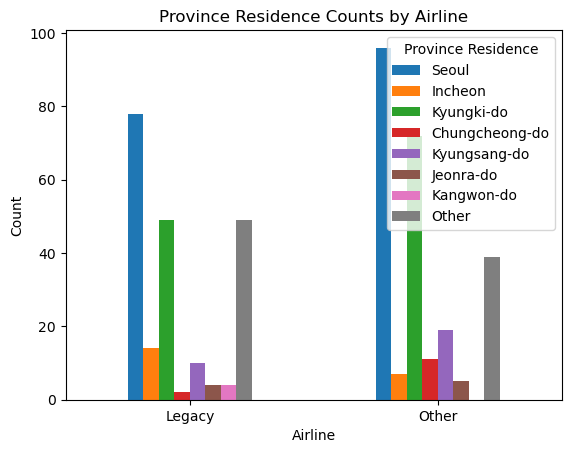

Sample size of each groups:
295
164
Chi-square test results:
Chi-square statistic: 2.1314890534203204, P-value: 0.14430051675116462
0.14430051675116462
We fail to reject the null hypothesis: There is no significant association between ProvinceResidence groups and airline choice.


In [123]:
#-------- PROVINCERESIDENCE ------------
#This varible is re-grouped base on location of each residence
#Visualization
province_residence_counts = airport.groupby('Airline[Legacy]')['ProvinceResidence'].value_counts().rename('Count').reset_index()
pivot_table = province_residence_counts.pivot(index='Airline[Legacy]', columns='ProvinceResidence', values='Count').fillna(0)
pivot_table.index = ['Legacy', 'Other']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Province Residence Counts by Airline')
plt.xticks(rotation=0)  # Set the x-axis labels to Airport names
plt.legend(title='Province Residence', labels=['Seoul', 'Incheon', 'Kyungki-do', 'Chungcheong-do', 'Kyungsang-do', 'Jeonra-do', 'Kangwon-do', 'Other'])  
plt.show()

#Check sample size of each group:
airport['ProvinceResidence[Seoul,Kyungki-do]'] = (airport['ProvinceResidence'].isin([1,3])).astype(int)
airport['ProvinceResidence[Other]'] = (airport['ProvinceResidence'].isin([2,4,5,6,7,8])).astype(int)
print('Sample size of each groups:')
print(airport['ProvinceResidence[Seoul,Kyungki-do]'].sum())
print(airport['ProvinceResidence[Other]'].sum())

#Chi-square:
contingency_table = pd.crosstab(index=airport['Airline[Legacy]'],
                                columns=[airport['ProvinceResidence[Seoul,Kyungki-do]'], airport['ProvinceResidence[Other]']])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test results:\nChi-square statistic: {chi2}, P-value: {p}")
alpha = 0.1
print(p)
if p < alpha:
    print("We reject the null hypothesis: There is a significant association between ProvinceResidence groups and airline choice.")
else:
    print("We fail to reject the null hypothesis: There is no significant association between ProvinceResidence groups and airline choice.")


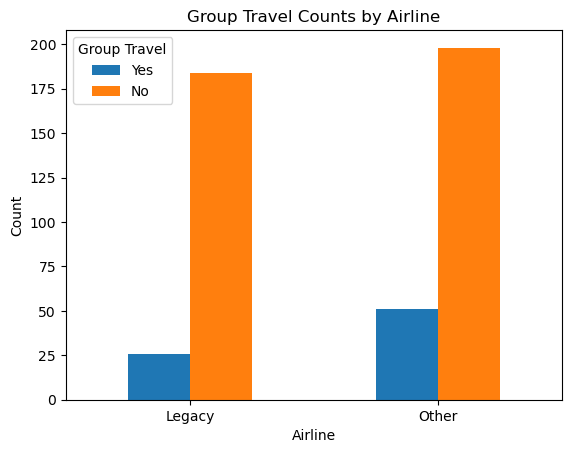

Sample size of each groups:
77
382
Chi-square test results:
Chi-square statistic: 4.790383135959123, P-value: 0.028619059958241547
We reject the null hypothesis: There is a significant association between GroupTravel and Airline selection.


In [87]:
#------- GROUPTRAVEL----------
#Visualization
gt_counts = airport.groupby('Airline[Legacy]')['GroupTravel'].value_counts().rename('Count').reset_index()

pivot_table = gt_counts.pivot(index='Airline[Legacy]', columns='GroupTravel', values='Count').fillna(0)

pivot_table.index = ['Legacy', 'Other']
pivot_table.plot(kind='bar', stacked=False)

plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Group Travel Counts by Airline')
plt.xticks(rotation=0)  
plt.legend(title='Group Travel', labels=['Yes', 'No'])
plt.show()

#Check sample size of each group:
airport['GroupTravel[Yes]'] = (airport['GroupTravel'].isin([1])).astype(int)
airport['GroupTravel[No]'] = (airport['GroupTravel'].isin([2])).astype(int)
print('Sample size of each groups:')
print(airport['GroupTravel[Yes]'].sum())
print(airport['GroupTravel[No]'].sum())

#Chi-square:
contingency_table = pd.crosstab(airport['Airline[Legacy]'], [airport['GroupTravel[Yes]'], airport['GroupTravel[No]']])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square test results:\nChi-square statistic: {chi2}, P-value: {p}")
alpha = 0.05
if p < alpha:
    print("We reject the null hypothesis: There is a significant association between GroupTravel and Airline selection.")
else:
    print("We fail to reject the null hypothesis: There is no significant association between GroupTravel and Airline selection.")


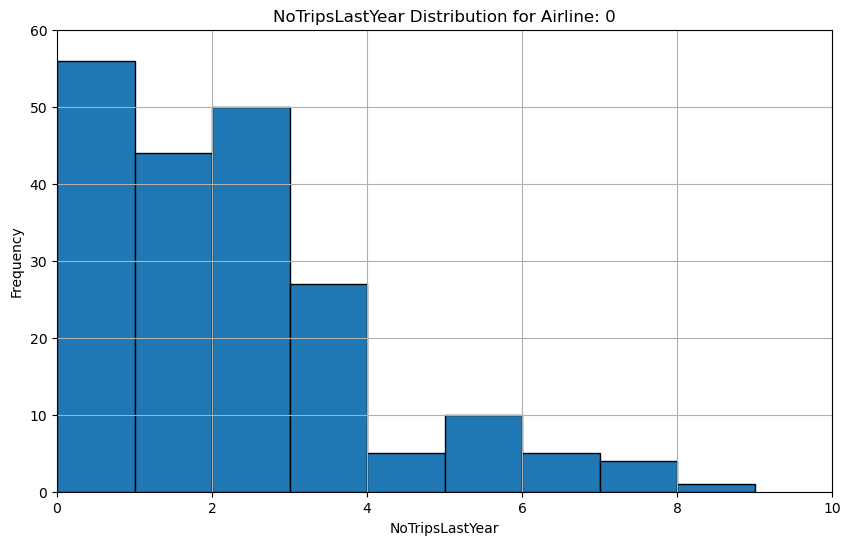

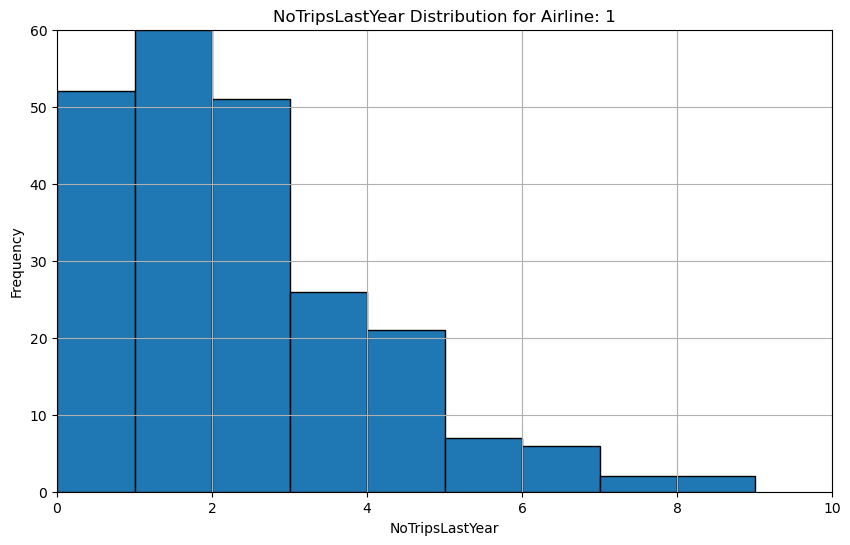


ANOVA test result:
The p-value is less than 0.1 , so we reject the null hypothesis.
There is a statistically significant difference in average NoTripsLastYear between Airport 1 and Airport 2.


In [126]:
#--------- NoTripsLastYear -----------
#Visualization
grouped = airport.groupby('Airline[Legacy]')
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['NoTripsLastYear'], bins=range(0, 10, 1)) #Already exclude outliners
    max_count = max(max_count, max(counts))
for name, group in grouped:
    plt.figure(figsize=(10, 6))
    plt.hist(group['NoTripsLastYear'], bins=range(0, 10, 1), edgecolor='black')
    plt.title(f'NoTripsLastYear Distribution for Airline: {name}')
    plt.xlabel('NoTripsLastYear')
    plt.ylabel('Frequency')
    plt.ylim(0, max_count)  
    plt.xlim(0, 10)  
    plt.grid(True)
    plt.show()
    
#ANOVA Test
airport_1 = airport[airport['Airline[Legacy]'] == 1]['NoTripsLastYear']
airport_2 = airport[airport['Airline[Legacy]'] == 0]['NoTripsLastYear']
anova_result = f_oneway(airport_1, airport_2)
alpha = 0.1
print('\nANOVA test result:')
if anova_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average NoTripsLastYear between Airport 1 and Airport 2.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average NoTripsLastYear between Airport 1 and Airport 2.")

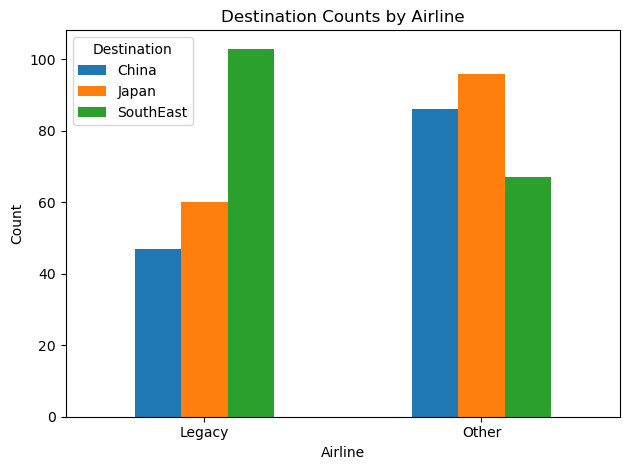

Sample size of each groups:
133
156
170

Chi-square test results:
Chi-square statistic: 24.228502810714076, P-value: 5.480844268056039e-06
We reject the null hypothesis: There is a significant association between Destination and Airline selection.


In [127]:
#------- DESTINATION -------
#Visualization:
Destination_counts = airport.groupby('Airline[Legacy]')['Destination'].value_counts().rename('Count').reset_index()
pivot_table = Destination_counts.pivot(index= 'Airline[Legacy]', columns='Destination', values='Count').fillna(0)
pivot_table.index = ['Legacy', 'Other']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Destination Counts by Airline')
plt.xticks(rotation=0)  # Set the x-axis labels to Airport names
plt.legend(title='Destination', labels=['China', 'Japan', 'SouthEast'])  
plt.tight_layout()
plt.show()

#Checking sample size each group:
airport['Destination[China]'] = (airport['Destination'] == 1).astype(int)
airport['Destination[Japan]'] = (airport['Destination'] == 2).astype(int)
airport['Destination[SE]'] = (airport['Destination'] == 3).astype(int)
print('Sample size of each groups:')
print(airport['Destination[China]'].sum())
print(airport['Destination[Japan]'].sum())
print(airport['Destination[SE]'].sum())

#Chi-Square
contingency_table = pd.crosstab(airport['Airline[Legacy]'], airport['Destination'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test results:\nChi-square statistic: {chi2}, P-value: {p}")
alpha = 0.05
if p < alpha:
    print("We reject the null hypothesis: There is a significant association between Destination and Airline selection.")
else:
    print("We fail to reject the null hypothesis: There is no significant association between Destination and Airline selection.")

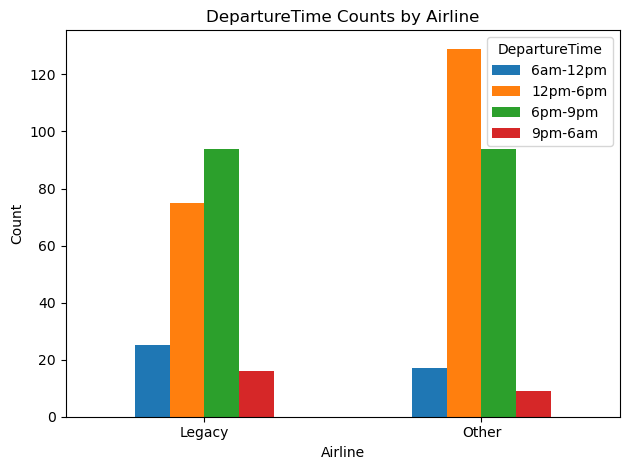


Chi-square test results:
Chi-square statistic: 14.56938455864273, P-value: 0.002224190582566828
We reject the null hypothesis: There is a significant association between DepartureTime and Airline selection.


In [129]:
#--------- DEPARTURETIME------------
#Visualization
DepartureTime_counts = airport.groupby('Airline[Legacy]')['DepartureTime'].value_counts().rename('Count').reset_index()
pivot_table = DepartureTime_counts.pivot(index= 'Airline[Legacy]', columns='DepartureTime', values='Count').fillna(0)
pivot_table.index = ['Legacy', 'Other']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('DepartureTime Counts by Airline')
plt.xticks(rotation=0)  # Set the x-axis labels to Airport names
plt.legend(title='DepartureTime', labels=["6am-12pm", "12pm-6pm", "6pm-9pm", "9pm-6am"])  # Update legend to match province residences
plt.tight_layout()
plt.show()

#Chi-square
contingency_table = pd.crosstab(airport['Airline[Legacy]'], airport['DepartureTime'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test results:\nChi-square statistic: {chi2}, P-value: {p}")
alpha = 0.01
if p < alpha:
    print("We reject the null hypothesis: There is a significant association between DepartureTime and Airline selection.")
else:
    print("We fail to reject the null hypothesis: There is no significant association between DepartureTime and Airline selection.")

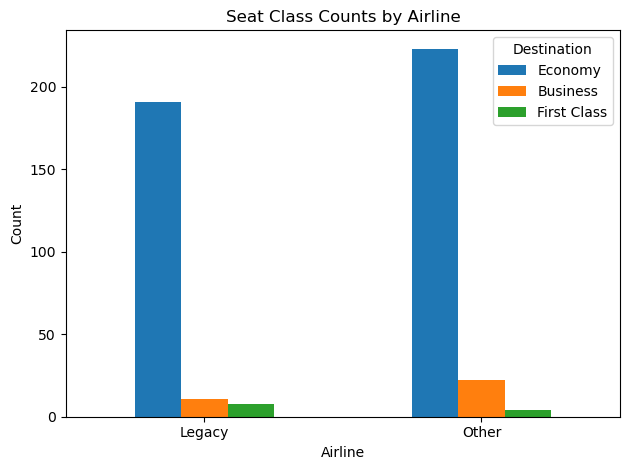

Sample size of each groups:
414
33
12

Chi-square test results:
Chi-square statistic: 4.189953603232807, P-value: 0.12307309871780565
We fail to reject the null hypothesis: There is no significant association between SeatClass and Airline selection.


In [98]:
#-------- SEATCLASS ------------
#Visualization
sc_counts = airport.groupby('Airline[Legacy]')['SeatClass'].value_counts().rename('Count').reset_index()
pivot_table = sc_counts.pivot(index= 'Airline[Legacy]', columns='SeatClass', values='Count').fillna(0)
pivot_table.index = ['Legacy', 'Other']
pivot_table.plot(kind='bar', stacked=False)
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Seat Class Counts by Airline')
plt.xticks(rotation=0)  # Set the x-axis labels to Airport names
plt.legend(title='Destination', labels=['Economy', 'Business', 'First Class'])  
plt.tight_layout()
plt.show()

#Check sample size each group:
airport['SeatClass[Eco]'] = (airport['SeatClass'] == 1).astype(int)
airport['SeatClass[Business]'] = (airport['SeatClass'] == 2).astype(int)
airport['SeatClass[FirstClass]'] = (airport['SeatClass'] == 3).astype(int)
print('Sample size of each groups:')
print(airport['SeatClass[Eco]'].sum())
print(airport['SeatClass[Business]'].sum())
print(airport['SeatClass[FirstClass]'].sum())
#Insufficient sample size for Chi-square

contingency_table = pd.crosstab(airport['Airline[Legacy]'], airport['SeatClass'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square test results:\nChi-square statistic: {chi2}, P-value: {p}")
alpha = 0.05
if p < alpha:
    print("We reject the null hypothesis: There is a significant association between SeatClass and Airline selection.")
else:
    print("We fail to reject the null hypothesis: There is no significant association between SeatClass and Airline selection.")

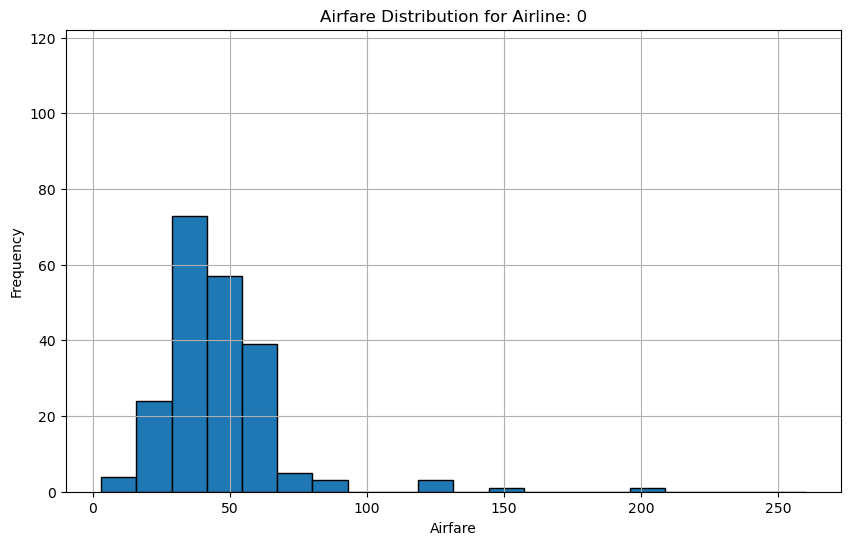

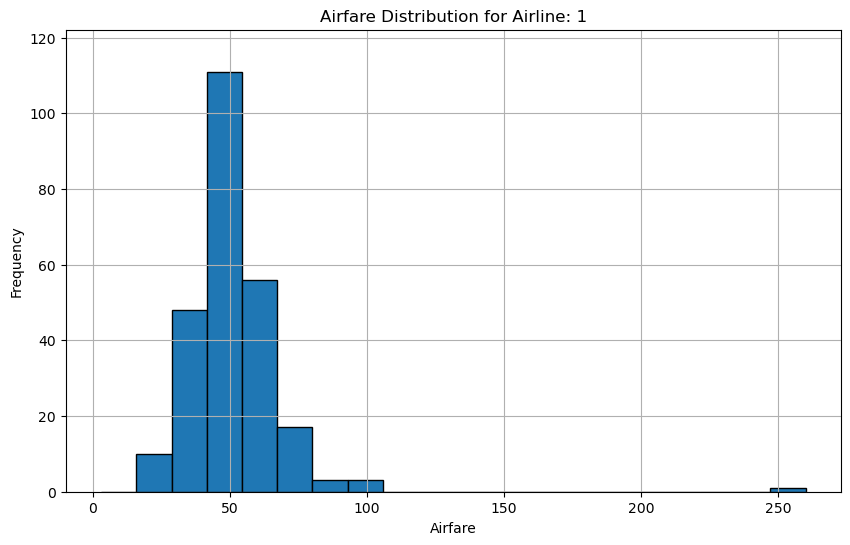


ANOVA test result:
The p-value is less than 0.05 , so we reject the null hypothesis.
There is a statistically significant difference in average Airfare between Airline choice.


In [102]:
#--------- AIRFARE -----------
#Histogram - Check for Normal Distribution
grouped = airport.groupby('Airline[Legacy]')
af_min = airport['Airfare'].min()
af_max = airport['Airfare'].max()
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['Airfare'], bins=20, range=(af_min, af_max))
    max_count = max(max_count, counts.max())
for i, (name, group) in enumerate(grouped, start=1):
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(group['Airfare'], bins=20, edgecolor='black', range=(af_min, af_max))    
    plt.ylim(0, max_count * 1.1)  
    plt.title(f'Airfare Distribution for Airline: {name}')
    plt.xlabel('Airfare')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
#ANOVA
airport_1 = airport[airport['Airline[Legacy]'] == 1]['Airfare']
airport_2 = airport[airport['Airline[Legacy]'] == 0]['Airfare']
anova_result = f_oneway(airport_1, airport_2)
alpha = 0.05
print('\nANOVA test result:')
if anova_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average Airfare between Airline choice.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average Airfare between Airline choice.")

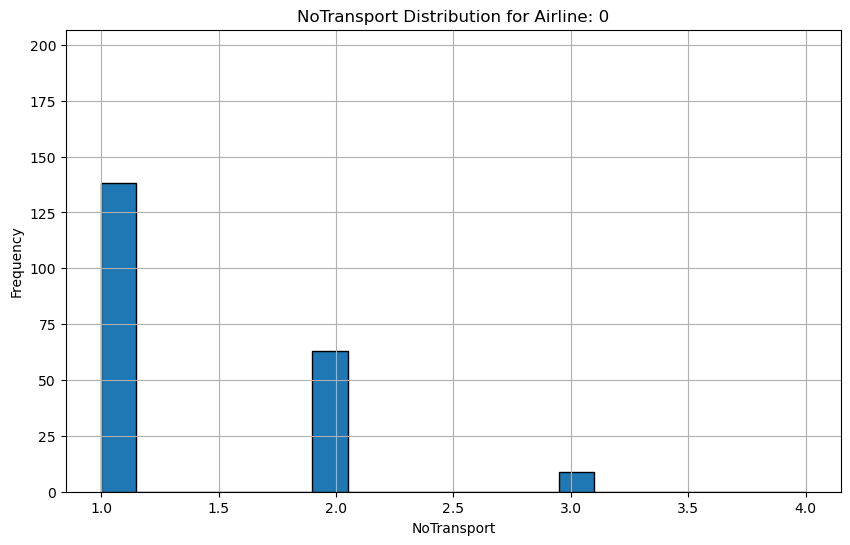

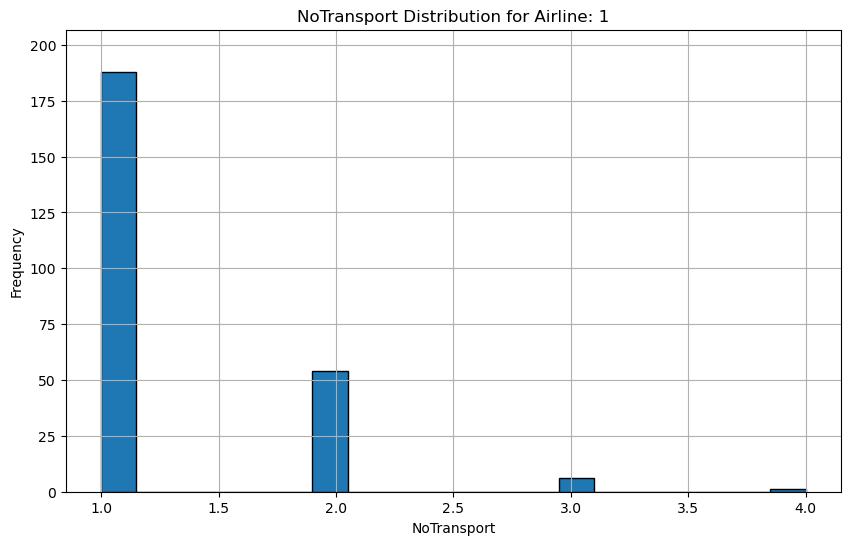


KRUSKAL test result:
The p-value is less than 0.05 , so we reject the null hypothesis.
There is a statistically significant difference in average NoTransport between Airline choice.


In [105]:
#------ NoTransport -------
#Histogram - Check for Normal Distribution
grouped = airport.groupby('Airline[Legacy]')
nt_min = airport['NoTransport'].min()
nt_max = airport['NoTransport'].max()
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['NoTransport'], bins=20, range=(nt_min, nt_max))
    max_count = max(max_count, counts.max())
for i, (name, group) in enumerate(grouped, start=1):
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(group['NoTransport'], bins=20, edgecolor='black', range=(nt_min, nt_max))    
    plt.ylim(0, max_count * 1.1)  # Add a little extra space at the top    
    plt.title(f'NoTransport Distribution for Airline: {name}')
    plt.xlabel('NoTransport')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
#KRUSKAL
airport_1 = airport[airport['Airline[Legacy]'] == 1]['NoTransport']
airport_2 = airport[airport['Airline[Legacy]'] == 0]['NoTransport']
kruskal_result = f_oneway(airport_1, airport_2)
alpha = 0.05
print('\nKRUSKAL test result:')
if kruskal_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average NoTransport between Airline choice.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average NoTransport between Airline choice.")

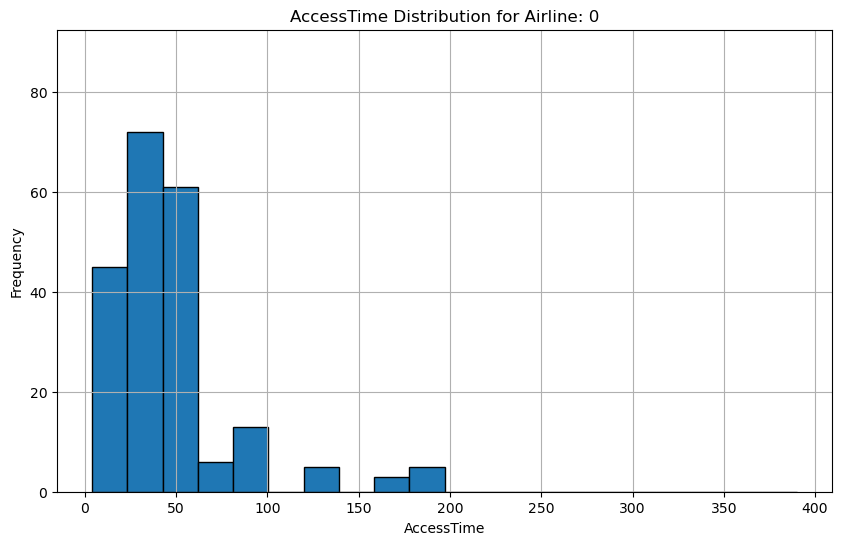

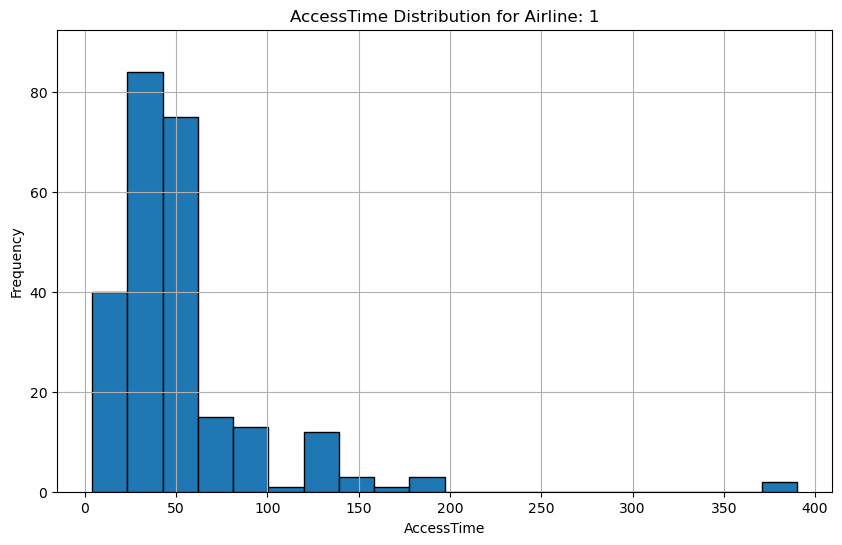


KRUSKAL test result:
0.07309185919228951
The p-value is less than 0.1 , so we reject the null hypothesis.
There is a statistically significant difference in average AccessTime between Airline choice.


In [114]:
#-------- AccessTime -----------
#Histogram - Check for Normal Distribution
grouped = airport.groupby('Airline[Legacy]')
ct_min = airport['AccessTime'].min()
ct_max = airport['AccessTime'].max()
max_count = 0
for name, group in grouped:
    counts, _ = np.histogram(group['AccessTime'], bins=20, range=(ct_min, ct_max))
    max_count = max(max_count, counts.max())
for i, (name, group) in enumerate(grouped, start=1):
    plt.figure(figsize=(10, 6))
    counts, bins, patches = plt.hist(group['AccessTime'], bins=20, edgecolor='black', range=(ct_min, ct_max))    
    plt.ylim(0, max_count * 1.1)  # Add a little extra space at the top    
    plt.title(f'AccessTime Distribution for Airline: {name}')
    plt.xlabel('AccessTime')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

#KRUSKAL
airport_1 = airport[airport['Airline[Legacy]'] == 1]['AccessTime']
airport_2 = airport[airport['Airline[Legacy]'] == 0]['AccessTime']
kruskal_result = kruskal(airport_1, airport_2)
alpha = 0.10
print('\nKRUSKAL test result:')
print(kruskal_result.pvalue)
if kruskal_result.pvalue < alpha:
    print("The p-value is less than", alpha, ", so we reject the null hypothesis.")
    print("There is a statistically significant difference in average AccessTime between Airline choice.")
else:
    print("The p-value is greater than or equal to", alpha, ", so we fail to reject the null hypothesis.")
    print("There is no statistically significant difference in average AccessTime between Airline choice.")